<a href="https://colab.research.google.com/github/arinafil/Defense-predictor/blob/main/%D1%81%D1%80%D0%B0%D0%B2_defense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt


#Defense predictor
Берем первые три генома. Данные взяты с сервера, они были проаннотированы prokka, а после прогнаны через defense-predictor.
Сейчас посмотрим на диаграммы распределения. Выделим трешхолд, а также уберем все уже известные защитные системы.

In [ ]:
gen_1=pd.read_csv('/content/GCF_003335465.1.csv')
gen_1.head()

,protein_context_id,product_accession,name,symbol,genomic_accession,start,end,strand,dna_seq,protein_seq,defense_probability,defense_log_odds
0,JIHHCFLG_00001|gnl|Prokka|JIHHCFLG_3|84|-,JIHHCFLG_00001,Glutamate racemase,murI,gnl|Prokka|JIHHCFLG_3,84,941,-,ATGGCTACCAAACTGCAGGACGGGAATATACCTTGTCTGGCAGCTA...,MATKLQDGNIPCLAATPSEPRPTVLVFDSGVGGLSVYDEIRHLLPD...,2.451926e-11,-24.431562
1,JIHHCFLG_00002|gnl|Prokka|JIHHCFLG_3|886|-,JIHHCFLG_00002,Vitamin B12 transporter BtuB,btuB_1,gnl|Prokka|JIHHCFLG_3,886,2724,-,ATGATTAAAAAAGCTTCGCTGCTGACGGCGTGTTCCGTCACGGCAT...,MIKKASLLTACSVTAFSAWAQDTSPDTLVVTANRFQQPINTVLAPT...,2.722969e-11,-24.326713
2,JIHHCFLG_00003|gnl|Prokka|JIHHCFLG_3|3093|+,JIHHCFLG_00003,tRNA/tmRNA (uracil-C(5))-methyltransferase,trmA,gnl|Prokka|JIHHCFLG_3,3093,4193,+,ATGACCCCCGAACACCTTCCAACAGAACAGTATGAAGCGCAGTTAG...,MTPEHLPTEQYEAQLAEKVVRLQSMMAPFSDLVPEVFRSPVSHYRM...,1.051367e-06,-13.765418
3,JIHHCFLG_00004|gnl|Prokka|JIHHCFLG_3|4233|-,JIHHCFLG_00004,Inner membrane protein YijD,yijD,gnl|Prokka|JIHHCFLG_3,4233,4592,-,ATGAAACAAGCAAATCAAGATAGAGGTACGCTGCTGCTAGCGTTGG...,MKQANQDRGTLLLALVAGLSINGTFAALFSSIVPFSVFPIISLVLT...,9.943409e-09,-18.426356
4,JIHHCFLG_00005|gnl|Prokka|JIHHCFLG_3|4592|-,JIHHCFLG_00005,HTH-type transcriptional repressor FabR,fabR,gnl|Prokka|JIHHCFLG_3,4592,5296,-,ATGTTCATTCTCTGGTATAGTGCCAGCAGTACTTTTGGCAAGGATT...,MFILWYSASSTFGKDSDIVMGVRAQQKEKTRRSLVEAAFSQLSAER...,1.294200e-10,-22.767958


In [ ]:
gen_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4420 entries, 0 to 4419
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   protein_context_id   4420 non-null   object 
 1   product_accession    4420 non-null   object 
 2   name                 4420 non-null   object 
 3   symbol               3414 non-null   object 
 4   genomic_accession    4420 non-null   object 
 5   start                4420 non-null   int64  
 6   end                  4420 non-null   int64  
 7   strand               4420 non-null   object 
 8   dna_seq              4420 non-null   object 
 9   protein_seq          4420 non-null   object 
 10  defense_probability  4420 non-null   float64
 11  defense_log_odds     4420 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 414.5+ KB


**Для определения thresholds для классификации генов, как защитный используются:**

1)Логарифм отношения шансов $log-odds\geq7.2$
\
$log-odds=log(\frac{p}{1-p})$, где p -предсказанная моделью вероятность того , что ген является защитным (defense_probability)

2) Для калибровки порога на валидационных данных использовалась кривая Precision-recall:
Модель оценивалась по Average Precision (AP = 0.95), что показывает высокую точность при различной полноте (recall).

Оптимальный баланс между precision и recall определялся на тестовом наборе данных, чтобы минимизировать ложные срабатывания.

Построим диаграмму распределения для defense_probability в лагарифмической шкале(так как згначения очень маленькие), а потом для defense_log_odds.

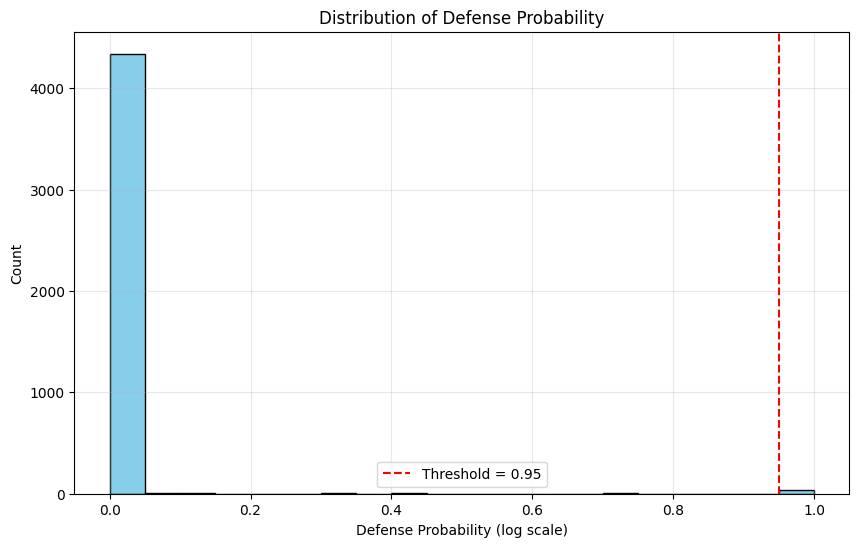

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(gen_1['defense_probability'], bins=20, edgecolor='black', color='skyblue')
plt.axvline(x=0.95, color='red', linestyle='--', label='Threshold = 0.95')
plt.xlabel('Defense Probability (log scale)')
plt.ylabel('Count')
plt.title('Distribution of Defense Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Видим , что значения очень маленькие, поэтому будем использовать дальше defense_log_odds

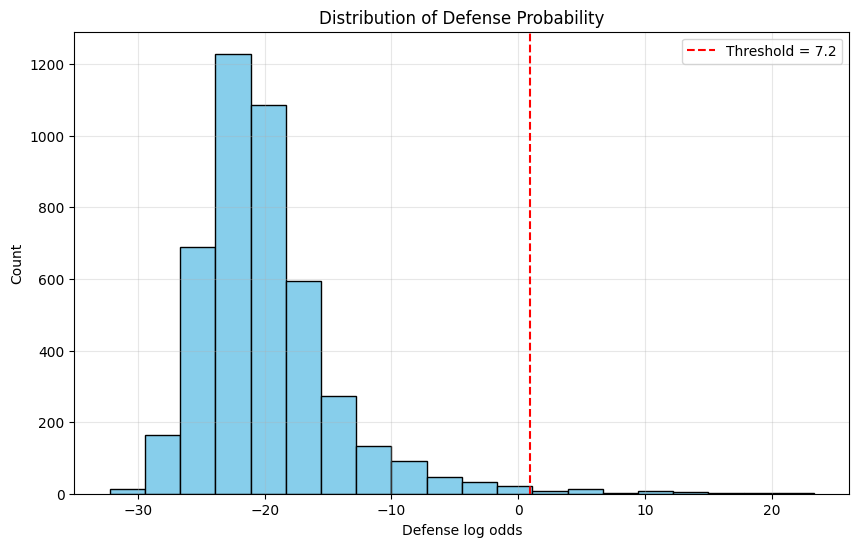

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(gen_1['defense_log_odds'], bins=20, edgecolor='black', color='skyblue')
plt.axvline(x=0.95, color='red', linestyle='--', label='Threshold = 7.2')
plt.xlabel('Defense log odds')
plt.ylabel('Count')
plt.title('Distribution of Defense Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
def_pred_df=gen_1[gen_1['defense_log_odds']>7.2]
def_pred_df.count()

,0
protein_context_id,21
product_accession,21
name,21
symbol,3
genomic_accession,21
start,21
end,21
strand,21
dna_seq,21
protein_seq,21


Уберем уже извесные защитные системы, оставим только те которые предположительно могут ими являться

In [ ]:
gen_1_hyp=gen_1[gen_1['name']=='hypothetical protein']
gen_1_hyp.count()

,0
protein_context_id,939
product_accession,939
name,939
symbol,0
genomic_accession,939
start,939
end,939
strand,939
dna_seq,939
protein_seq,939


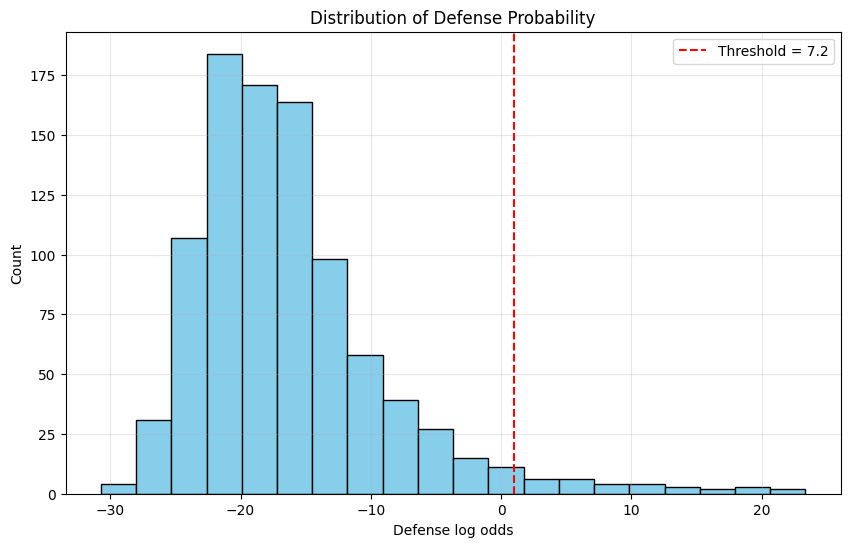

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(gen_1_hyp['defense_log_odds'], bins=20, edgecolor='black', color='skyblue')
plt.axvline(x=0.95, color='red', linestyle='--', label='Threshold = 7.2')
plt.xlabel('Defense log odds')
plt.ylabel('Count')
plt.title('Distribution of Defense Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Посчитаем , сколько предположительно новых защитных систем удалось обнаружить с помощью defense predictor

In [ ]:
def_pred_df_hyp=gen_1_hyp[gen_1_hyp['defense_log_odds']>7.2]
def_pred_df_hyp.count()

,0
protein_context_id,18
product_accession,18
name,18
symbol,0
genomic_accession,18
start,18
end,18
strand,18
dna_seq,18
protein_seq,18


#2

In [ ]:
gen_2=pd.read_csv('/content/GCF_003334815.1.csv')
gen_2.head()

,protein_context_id,product_accession,name,symbol,genomic_accession,start,end,strand,dna_seq,protein_seq,defense_probability,defense_log_odds
0,LMADKNAO_00001|gnl|Prokka|LMADKNAO_1|7|+,LMADKNAO_00001,Protein RhsC,rhsC,gnl|Prokka|LMADKNAO_1,7,804,+,ATGGACCCGGTGTACACGCCGGCGCGAAAAATCCACCTGTACCACT...,MDPVYTPARKIHLYHCDHRGLPLALVSTEGATEWCAEYDEWGNLLN...,3.320851e-10,-21.825630
1,LMADKNAO_00002|gnl|Prokka|LMADKNAO_1|804|+,LMADKNAO_00002,hypothetical protein,NaN,gnl|Prokka|LMADKNAO_1,804,1130,+,ATGAAATATATTATTTTTTTATTCAGAGCTATATGGCTGGCTTTAT...,MKYIIFLFRAIWLALSLLILFFSMHRLSLLDSTRDVSELISLMSYG...,1.583043e-06,-13.356160
2,LMADKNAO_00003|gnl|Prokka|LMADKNAO_2|646|-,LMADKNAO_00003,hypothetical protein,NaN,gnl|Prokka|LMADKNAO_2,646,888,-,ATGGGATATATCACATATGTTACAGATCAACGACCCGGTGAACCAG...,MGYITYVTDQRPGEPDILTGNTFADLEIRDSDGHLLLKVSAPEAGW...,8.247251e-10,-20.915971
3,LMADKNAO_00004|gnl|Prokka|LMADKNAO_2|1047|-,LMADKNAO_00004,hypothetical protein,NaN,gnl|Prokka|LMADKNAO_2,1047,1208,-,ATGCTGATGAAACAGTTAGGGCAAATCAATGATGAACTGGGGGCGC...,MLMKQLGQINDELGALLDSVENHTPVIRKKASDLSALMMLFSQQAG...,8.474683e-09,-18.586183
4,LMADKNAO_00005|gnl|Prokka|LMADKNAO_3|32|-,LMADKNAO_00005,Cytoskeleton-binding toxin CbtA,cbtA,gnl|Prokka|LMADKNAO_3,32,406,-,ATGAAAACATTACCCGACACGCATGTACGGGAGGTATCGTGCTGCC...,MKTLPDTHVREVSCCPSPVTIWQTLLSRLLGQHYSLTLNDTPFVDE...,1.116490e-07,-16.007906


In [ ]:
gen_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4634 entries, 0 to 4633
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   protein_context_id   4634 non-null   object 
 1   product_accession    4634 non-null   object 
 2   name                 4634 non-null   object 
 3   symbol               3483 non-null   object 
 4   genomic_accession    4634 non-null   object 
 5   start                4634 non-null   int64  
 6   end                  4634 non-null   int64  
 7   strand               4634 non-null   object 
 8   dna_seq              4634 non-null   object 
 9   protein_seq          4634 non-null   object 
 10  defense_probability  4634 non-null   float64
 11  defense_log_odds     4634 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 434.6+ KB


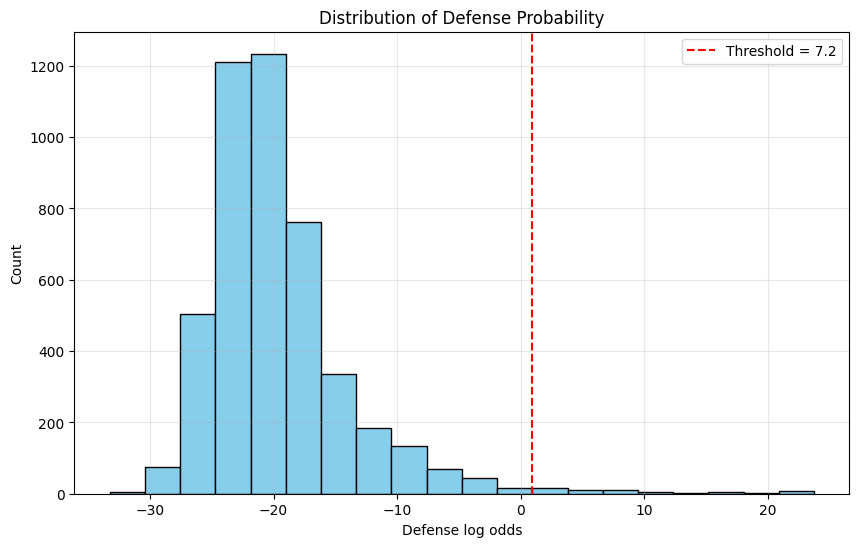

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(gen_2['defense_log_odds'], bins=20, edgecolor='black', color='skyblue')
plt.axvline(x=0.95, color='red', linestyle='--', label='Threshold = 7.2')
plt.xlabel('Defense log odds')
plt.ylabel('Count')
plt.title('Distribution of Defense Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
def_pred_df_2=gen_2[gen_2['defense_log_odds']>7.2]
def_pred_df_2.count()

,0
protein_context_id,27
product_accession,27
name,27
symbol,10
genomic_accession,27
start,27
end,27
strand,27
dna_seq,27
protein_seq,27


In [ ]:
gen_2_hyp=gen_2[gen_2['name']=='hypothetical protein']
gen_2_hyp.count()

,0
protein_context_id,1075
product_accession,1075
name,1075
symbol,0
genomic_accession,1075
start,1075
end,1075
strand,1075
dna_seq,1075
protein_seq,1075


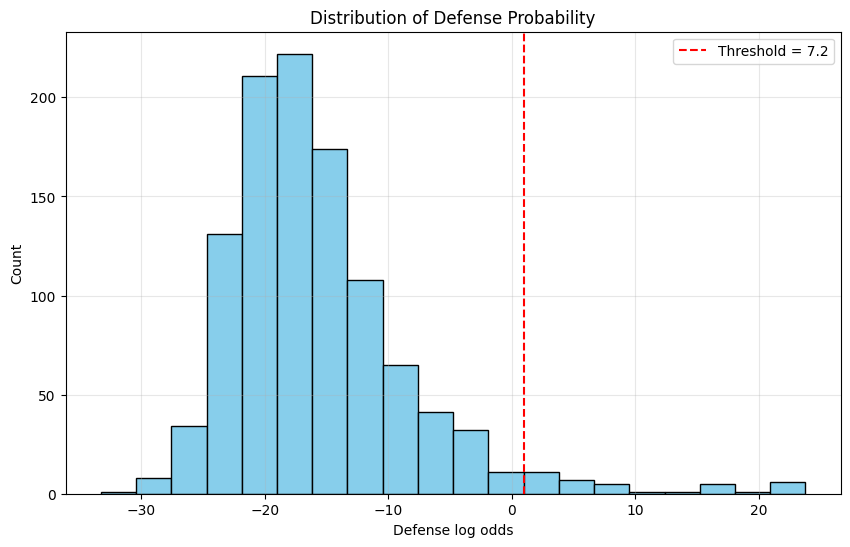

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(gen_2_hyp['defense_log_odds'], bins=20, edgecolor='black', color='skyblue')
plt.axvline(x=0.95, color='red', linestyle='--', label='Threshold = 7.2')
plt.xlabel('Defense log odds')
plt.ylabel('Count')
plt.title('Distribution of Defense Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
def_pred_df_hyp_2=gen_2_hyp[gen_2_hyp['defense_log_odds']>7.2]
def_pred_df_hyp_2.count()

,0
protein_context_id,17
product_accession,17
name,17
symbol,0
genomic_accession,17
start,17
end,17
strand,17
dna_seq,17
protein_seq,17


#3

In [ ]:
gen_3=pd.read_csv('/content/GCF_003334785.1.csv')
gen_3.head()

,protein_context_id,product_accession,name,symbol,genomic_accession,start,end,strand,dna_seq,protein_seq,defense_probability,defense_log_odds
0,LJAKIAKM_00001|gnl|Prokka|LJAKIAKM_2|433|-,LJAKIAKM_00001,Nickel-responsive regulator,nikR,gnl|Prokka|LJAKIAKM_2,433,834,-,ATGCAACGAGTCACCATCACGCTTGATGACGATTTACTGGAGACGC...,MQRVTITLDDDLLETLDSLSQRRGYNNRSEAIRDILRSALAQEATQ...,5.946904e-09,-18.940395
1,LJAKIAKM_00002|gnl|Prokka|LJAKIAKM_2|840|-,LJAKIAKM_00002,Nickel import ATP-binding protein NikE,nikE,gnl|Prokka|LJAKIAKM_2,840,1646,-,ATGACTTTACTTAACATCTCCGGCCTTTCCCATCACTATGCGCACG...,MTLLNISGLSHHYAHGGFNGKHQHQAVLNNVSLTLKSGETVALLGR...,1.780072e-08,-17.844027
2,LJAKIAKM_00003|gnl|Prokka|LJAKIAKM_2|1643|-,LJAKIAKM_00003,Nickel import ATP-binding protein NikD,nikD,gnl|Prokka|LJAKIAKM_2,1643,2407,-,ATGCCGCAACAGATTGAACTACGTAATATCGCGCTACAGGCCGCGC...,MPQQIELRNIALQAAQPLVHGVSLTLQRGRVLALVGGSGSGKSLTC...,2.480791e-10,-22.117273
3,LJAKIAKM_00004|gnl|Prokka|LJAKIAKM_2|2407|-,LJAKIAKM_00004,Nickel transport system permease protein NikC,nikC,gnl|Prokka|LJAKIAKM_2,2407,3240,-,GTGAACTTTTTCCTCTCTTCCCGCTGGTCGGTACGCCTGGCGCTGA...,MNFFLSSRWSVRLALIIIALLALIALTSQWWLPYDPQAIDLPSRLL...,5.183304e-12,-25.985578
4,LJAKIAKM_00005|gnl|Prokka|LJAKIAKM_2|3237|-,LJAKIAKM_00005,Nickel transport system permease protein NikB,nikB,gnl|Prokka|LJAKIAKM_2,3237,4181,-,ATGTTGCGTTACGTATTACGCCGCTTTCTGCTGCTGATCCCGATGG...,MLRYVLRRFLLLIPMVLAASVIIFLMLRLGTGDPALDYLRLSNLPP...,5.012178e-11,-23.716565


In [ ]:
gen_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4399 entries, 0 to 4398
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   protein_context_id   4399 non-null   object 
 1   product_accession    4399 non-null   object 
 2   name                 4399 non-null   object 
 3   symbol               3436 non-null   object 
 4   genomic_accession    4399 non-null   object 
 5   start                4399 non-null   int64  
 6   end                  4399 non-null   int64  
 7   strand               4399 non-null   object 
 8   dna_seq              4399 non-null   object 
 9   protein_seq          4399 non-null   object 
 10  defense_probability  4399 non-null   float64
 11  defense_log_odds     4399 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 412.5+ KB


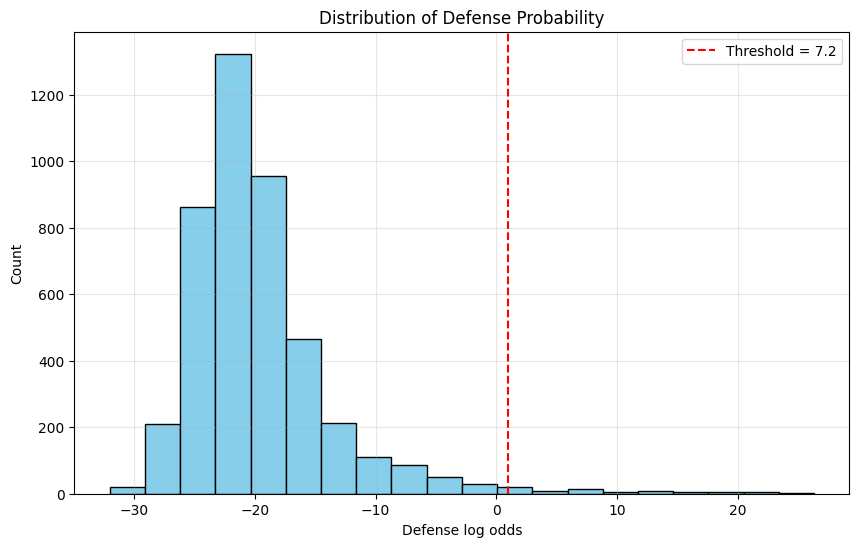

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(gen_3['defense_log_odds'], bins=20, edgecolor='black', color='skyblue')
plt.axvline(x=0.95, color='red', linestyle='--', label='Threshold = 7.2')
plt.xlabel('Defense log odds')
plt.ylabel('Count')
plt.title('Distribution of Defense Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
def_pred_df_3=gen_3[gen_3['defense_log_odds']>7.2]
def_pred_df_3.count()

,0
protein_context_id,41
product_accession,41
name,41
symbol,16
genomic_accession,41
start,41
end,41
strand,41
dna_seq,41
protein_seq,41


In [ ]:
gen_3_hyp=gen_3[gen_3['name']=='hypothetical protein']
gen_3_hyp.count()

,0
protein_context_id,882
product_accession,882
name,882
symbol,0
genomic_accession,882
start,882
end,882
strand,882
dna_seq,882
protein_seq,882


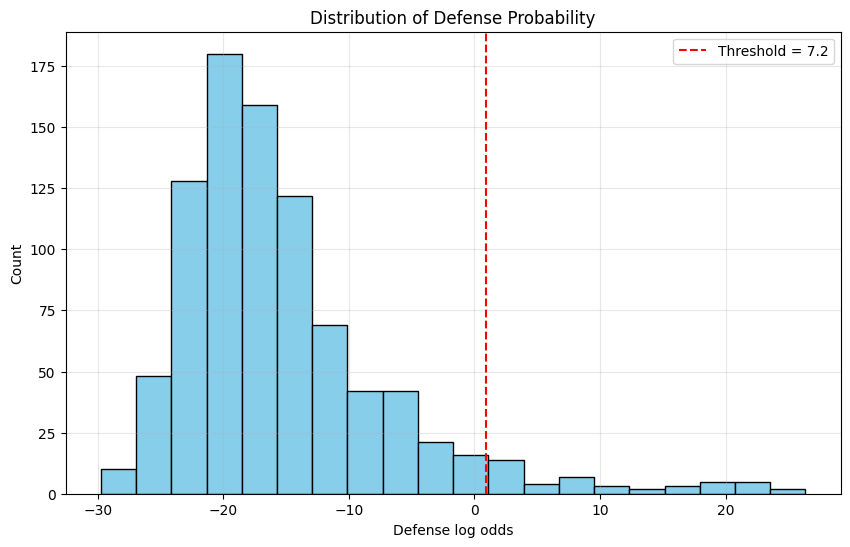

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(gen_3_hyp['defense_log_odds'], bins=20, edgecolor='black', color='skyblue')
plt.axvline(x=0.95, color='red', linestyle='--', label='Threshold = 7.2')
plt.xlabel('Defense log odds')
plt.ylabel('Count')
plt.title('Distribution of Defense Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
def_pred_df_hyp_3=gen_3_hyp[gen_3_hyp['defense_log_odds']>7.2]
def_pred_df_hyp_3.count()

,0
protein_context_id,25
product_accession,25
name,25
symbol,0
genomic_accession,25
start,25
end,25
strand,25
dna_seq,25
protein_seq,25


#Defense finder

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!mamba install -c bioconda defense-finder hmmer macsyfinder -y

✨🍰✨ Everything looks OK!

Looking for: ['defense-finder', 'hmmer', 'macsyfinder']

bioconda/linux-64                                           Using cache
bioconda/noarch                                             Using cache
conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache

Pinned packages:
  - python 3.11.*
  - python 3.11.*
  - python_abi 3.11.* *cp311*
  - cuda-version 12.*


Transaction

  Prefix: /usr/local

  All requested packages already installed



In [ ]:
!defense-finder update

Extracting defense-finder-models (2.0.2).
Installing defense-finder-models (2.0.2) in /root/.macsyfinder/models
Cleaning.
The models defense-finder-models (2.0.2) have been installed successfully.
Extracting CasFinder (3.1.0).
Extracting CasFinder (3.1.0).
Installing CasFinder (3.1.0) in /root/.macsyfinder/models
Installing CasFinder (3.1.0) in /root/.macsyfinder/models
Cleaning.
Cleaning.
The models CasFinder (3.1.0) have been installed successfully.
The models CasFinder (3.1.0) have been installed successfully.


In [ ]:
!mkdir -p results/defense_finder_results

In [ ]:
!defense-finder run \
    --out-dir results/defense_finder_results \
    --workers 2 \
    --coverage 0.4 \
    --db-type ordered_replicon \
    /content/GCF_003335465.1_ASM333546v1_genomic.fna

 2025-07-17 08:50:18 | INFO     | Received file /content/GCF_003335465.1_ASM333546v1_genomic.fna
 2025-07-17 08:50:18 | WARNING  | Out directory /content/results/defense_finder_results already exists. Existing DefenseFinder output will be overwritten
 2025-07-17 08:50:18 | INFO     | /content/GCF_003335465.1_ASM333546v1_genomic.fna is a nucleotide fasta file. Prodigal will annotate the CDS
 2025-07-17 08:50:27 | INFO     | Prodigal annotated 84 replicons
 2025-07-17 08:50:28 | INFO     | Protein files written in /content/results/defense_finder_results/GCF_003335465.1_ASM333546v1_genomic.prt
 2025-07-17 08:50:28 | INFO     | 4475 CDS were annotated
 2025-07-17 08:50:28 | INFO     | Awesome, you are using the last version of the defense-finder-models : 2.0.2
 2025-07-17 08:50:28 | INFO     | Running DefenseFinder version 2.0.1
 2025-07-17 08:50:28 | INFO     | Using the following models:

/root/.macsyfinder/models/CasFinder	3.1.0
/root/.macsyfinder/models/defense-finder-models	2.0.2

 20

Columns in hmmer.tsv: ['hit_id', 'replicon', 'hit_pos', 'hit_sequence_length', 'gene_name', 'i_eval', 'hit_score', 'hit_profile_cov', 'hit_seq_cov', 'hit_begin_match', 'hit_end_match']
                  hit_id           replicon  hit_pos  hit_sequence_length  \
0  NZ_QOZF01000010.1_111  NZ_QOZF01000010.1      112                  929   
1   NZ_QOZF01000011.1_22  NZ_QOZF01000011.1      141                 1487   
2   NZ_QOZF01000011.1_53  NZ_QOZF01000011.1      172                  685   
3   NZ_QOZF01000011.1_53  NZ_QOZF01000011.1      172                  685   
4  NZ_QOZF01000011.1_118  NZ_QOZF01000011.1      237                  178   

          gene_name        i_eval  hit_score  hit_profile_cov  hit_seq_cov  \
0      UG9__DNA_pol  3.900000e-37      126.3            0.715        0.422   
1  Wadjet__JetC_III  1.600000e-12       43.7            0.452        0.445   
2    Gabija__GajB_3  5.500000e-16       56.7            0.593        0.349   
3    Gabija__GajB_2  2.400000e-66      2

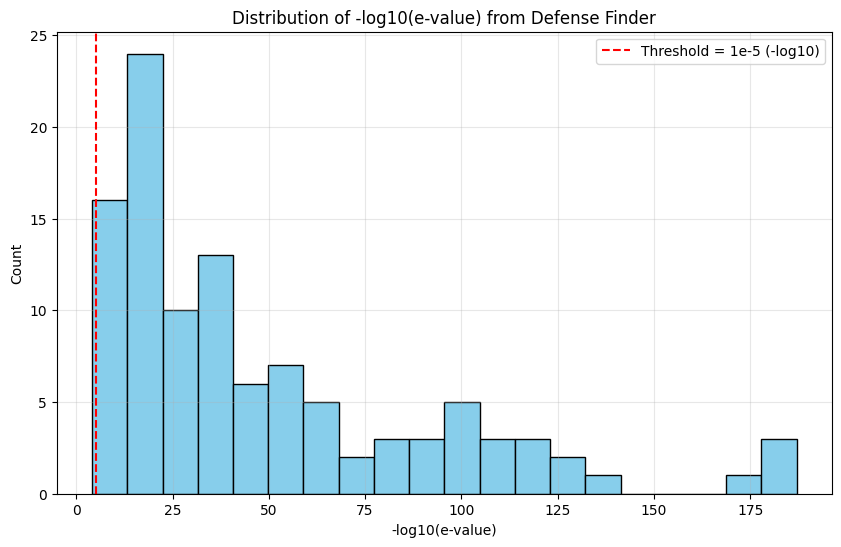

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

hmmer_file = "/content/results/defense_finder_results/GCF_003335465.1_ASM333546v1_genomic_defense_finder_hmmer.tsv"
df_hmmer = pd.read_csv(hmmer_file, sep='\t')

print("Columns in hmmer.tsv:", df_hmmer.columns.tolist())
print(df_hmmer.head())

e_values = df_hmmer['i_eval'].dropna().astype(float)


min_e_value = e_values[e_values > 0].min()
e_values = e_values.replace(0, min_e_value)
log_e_values = -np.log10(e_values)

log_e_values = log_e_values[np.isfinite(log_e_values)]

plt.figure(figsize=(10, 6))
plt.hist(log_e_values, bins=20, edgecolor='black', color='skyblue')
plt.axvline(x=-np.log10(1e-5), color='red', linestyle='--', label='Threshold = 1e-5 (-log10)')
plt.xlabel('-log10(e-value)')
plt.ylabel('Count')
plt.title('Distribution of -log10(e-value) from Defense Finder')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

PADLOC

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!mamba install -c conda-forge -c bioconda -c padlocbio padloc=2.0.0 hmmer -y

!padloc --db-update

✨🍰✨ Everything looks OK!

Looking for: ['padloc=2.0.0', 'hmmer']

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache
bioconda/linux-64                                           Using cache
bioconda/noarch                                             Using cache
warning  libmamba Could not parse mod/etag header
[+] 0.0s
[+] 0.1s
padlocbio/linux-64..  ⣾  [+] 0.2s
padlocbio/linux-64..  ⣾  padlocbio/linux-64 (check zst)                    
warning  libmamba Could not parse mod/etag header
[+] 0.0s
padlocbio/noarch (..  ⣾  padlocbio/noarch (check zst)                      
[+] 0.0s
padlocbio/linux-64  ⣾  [+] 0.1s
padlocbio/linux-64  ⣾  
padlocbio/noarch    ⣾  padlocbio/noarch                                  
[+] 0.2s
padlocbio/linux-64  ⣾  [+] 0.3s
padlocbio/linux-64  ⣾  padlocbio/linux-64                                

Pinned packages:
  - python 3.11.*
  - python 3.11.*
  - python_abi 3.11.* *cp

In [ ]:
!mkdir -p /content/results/padloc_output

!padloc --fna /content/GCF_003335465.1_ASM333546v1_genomic.fna --outdir /content/results/padloc_output --cpu 4

[09:10:36] >> Predicting protein-coding genes with prodigal
[09:10:47] >> Scanning GCF_003335465.1_ASM333546v1_genomic for defence system proteins
[09:15:05] >> Searching GCF_003335465.1_ASM333546v1_genomic for defence systems
Warning messages:
1: package ‘tidyverse’ was built under R version 4.3.3 
2: package ‘ggplot2’ was built under R version 4.3.3 
3: package ‘tibble’ was built under R version 4.3.3 
4: package ‘tidyr’ was built under R version 4.3.3 
5: package ‘readr’ was built under R version 4.3.3 
6: package ‘purrr’ was built under R version 4.3.3 
7: package ‘dplyr’ was built under R version 4.3.3 
8: package ‘stringr’ was built under R version 4.3.3 
9: package ‘forcats’ was built under R version 4.3.3 
10: package ‘lubridate’ was built under R version 4.3.3 
[09:16:27 AM] >> Writing output to '/content/results/padloc_output/GCF_003335465.1_ASM333546v1_genomic_padloc.csv'


In [ ]:
padloc=pd.read_csv('/content/results/padloc_output/GCF_003335465.1_ASM333546v1_genomic_padloc.csv')
padloc.head()

,system.number,seqid,system,target.name,hmm.accession,hmm.name,protein.name,full.seq.E.value,domain.iE.value,target.coverage,hmm.coverage,start,end,strand,target.description,relative.position,contig.end,all.domains,best.hits
0,1,NZ_QOZF01000009.1,PDC-S02,NZ_QOZF01000009.1_247,PDLC04807,PDC-S02_WP_151674975.1,PDC-S02,1.800000e-136,2.500000e-136,0.963,0.954,264084,265211,+,-,247,304,"PDLC04795,PDC-S02_WP_011937941.1, 1, 1.2e-89, ...","PDLC04807, PDC-S02_WP_151674975.1, 2.5e-136, 0..."
1,2,NZ_QOZF01000015.1,gop_beta_cll,NZ_QOZF01000015.1_153,PDLC02989,cll2,cll,2.900000e-113,3.200000e-113,0.989,0.989,167437,168231,+,-,153,164,"PDLC02989,cll2, 1, 3.2e-113, 0.989, 0.989","PDLC02989, cll2, 3.2e-113, 0.989, 0.989"
2,2,NZ_QOZF01000015.1,gop_beta_cll,NZ_QOZF01000015.1_154,PDLC02985,beta2,beta,7.300000e-188,8.200000e-188,0.992,0.994,168259,169326,-,-,154,164,"PDLC02985,beta2, 1, 8.2e-188, 0.992, 0.994","PDLC02985, beta2, 8.2e-188, 0.992, 0.994"
3,2,NZ_QOZF01000015.1,gop_beta_cll,NZ_QOZF01000015.1_155,PDLC03001,gop_ncbi,gop,3.900000e-70,4.700000e-70,0.985,0.992,169329,169730,-,-,155,164,"PDLC03001,gop_ncbi, 1, 4.7e-70, 0.985, 0.992","PDLC03001, gop_ncbi, 4.7e-70, 0.985, 0.992"
4,3,NZ_QOZF01000019.1,PDC-S04,NZ_QOZF01000019.1_61,PDLC04838,PDC-S04_WP_169250289.1,PDC-S04,5.800000e-75,6.400000e-75,0.970,0.938,67554,68156,+,-,61,84,"PDLC04838,PDC-S04_WP_169250289.1, 1, 6.4e-75, ...","PDLC04838, PDC-S04_WP_169250289.1, 6.4e-75, 0...."


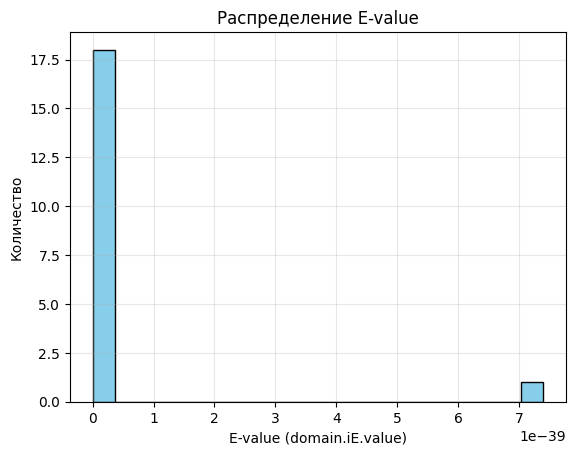

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.hist(padloc['domain.iE.value'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('E-value (domain.iE.value)')
plt.ylabel('Количество')
plt.title('Распределение E-value')
plt.grid(True, alpha=0.3)
plt.show()